In [5]:
import requests
from PIL import Image
import os
from io import BytesIO
from glob import glob
import albumentations as A
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split

# Download authentic images
os.makedirs('authentic_images', exist_ok=True)
api_key = "mOIOtvDb"
url = f"https://www.rijksmuseum.nl/api/en/collection?key={api_key}&ps=20&type=painting"
response = requests.get(url)
if response.status_code != 200:
    print(f"Error: {response.status_code} - {response.text}")
    raise Exception("Check API key.")

artworks = response.json()['artObjects']
authentic_images = []
for i, art in enumerate(artworks):
    img_url = art.get('webImage', {}).get('url')
    if img_url:
        img_response = requests.get(img_url, headers={'User-Agent': 'Mozilla/5.0'})
        if img_response.status_code == 200 and 'image' in img_response.headers['content-type']:
            img = Image.open(BytesIO(img_response.content))
            img_path = f'authentic_images/authentic_{i}.jpg'
            img.save(img_path)
            authentic_images.append(img_path)
            print(f"Saved {img_path}")

print(f"Downloaded {len(authentic_images)} images.")
!ls -l authentic_images/

# Generate fake images
os.makedirs('fake_images', exist_ok=True)
transform = A.Compose([
    A.GaussianBlur(blur_limit=(3, 7), p=0.7),
    A.GaussNoise(p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
    A.Rotate(limit=15, p=0.5),
])

fake_images = []
for path in authentic_images:
    image = cv2.imread(path)
    if image is None:
        print(f"Failed to load {path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented = transform(image=image)['image']
    fake_path = path.replace('authentic_images', 'fake_images').replace('authentic', 'fake')
    cv2.imwrite(fake_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
    fake_images.append(fake_path)
    print(f"Generated {fake_path}")

print(f"Generated {len(fake_images)} fakes.")
!ls -l fake_images/

# Update CSVs
authentic_labels = [1] * len(authentic_images)
fake_labels = [0] * len(fake_images)
all_paths = authentic_images + fake_images
all_labels = authentic_labels + fake_labels
df = pd.DataFrame({'image_path': all_paths, 'label': all_labels})
print(df.head())

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

# Download CSVs
from google.colab import files
files.download('train.csv')
files.download('test.csv')

Saved authentic_images/authentic_0.jpg
Saved authentic_images/authentic_1.jpg
Saved authentic_images/authentic_2.jpg
Saved authentic_images/authentic_3.jpg
Saved authentic_images/authentic_4.jpg
Saved authentic_images/authentic_5.jpg
Saved authentic_images/authentic_6.jpg
Saved authentic_images/authentic_7.jpg
Saved authentic_images/authentic_8.jpg
Saved authentic_images/authentic_9.jpg
Saved authentic_images/authentic_10.jpg
Saved authentic_images/authentic_11.jpg
Saved authentic_images/authentic_12.jpg
Saved authentic_images/authentic_13.jpg
Saved authentic_images/authentic_14.jpg
Saved authentic_images/authentic_15.jpg
Saved authentic_images/authentic_16.jpg
Saved authentic_images/authentic_17.jpg
Saved authentic_images/authentic_18.jpg
Saved authentic_images/authentic_19.jpg
Downloaded 20 images.
total 21480
-rw-r--r-- 1 root root  614031 Sep 18 18:49 authentic_0.jpg
-rw-r--r-- 1 root root  549677 Sep 18 18:49 authentic_10.jpg
-rw-r--r-- 1 root root  711700 Sep 18 18:49 authentic_1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Embeddings shape: (20, 512)
Similarity for fake_images/fake_6.jpg: 0.819


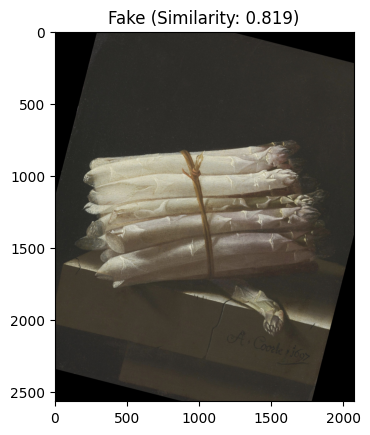

In [6]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from glob import glob

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

authentic_images = glob('authentic_images/authentic_*.jpg')
ref_images = [Image.open(p) for p in authentic_images]
ref_inputs = processor(images=ref_images, return_tensors="pt").to(device)
with torch.no_grad():
    ref_embeddings = model.get_image_features(**ref_inputs).cpu().numpy()

print(f"Embeddings shape: {ref_embeddings.shape}")

test_img = Image.open('fake_images/fake_6.jpg')
test_input = processor(images=test_img, return_tensors="pt").to(device)
with torch.no_grad():
    test_embedding = model.get_image_features(**test_input).cpu().numpy()

similarities = cosine_similarity(test_embedding, ref_embeddings)[0]
max_sim = np.max(similarities)
print(f"Similarity for fake_images/fake_6.jpg: {max_sim:.3f}")

import matplotlib.pyplot as plt
plt.imshow(test_img)
plt.title(f"Fake (Similarity: {max_sim:.3f})")
plt.show()

In [7]:
import pandas as pd

test_df = pd.read_csv('test.csv')
for idx, row in test_df.head(5).iterrows():
    path = row['image_path']
    label = row['label']
    test_img = Image.open(path)
    test_input = processor(images=test_img, return_tensors="pt").to(device)
    with torch.no_grad():
        test_embedding = model.get_image_features(**test_input).cpu().numpy()
    similarities = cosine_similarity(test_embedding, ref_embeddings)[0]
    max_sim = np.max(similarities)
    pred = "authentic" if max_sim > 0.8 else "fake"
    true = "authentic" if label == 1 else "fake"
    print(f"{path}: Similarity={max_sim:.3f}, Pred={pred}, True={true}")

fake_images/fake_7.jpg: Similarity=0.928, Pred=authentic, True=fake
fake_images/fake_14.jpg: Similarity=0.844, Pred=authentic, True=fake
authentic_images/authentic_17.jpg: Similarity=1.000, Pred=authentic, True=authentic
authentic_images/authentic_11.jpg: Similarity=1.000, Pred=authentic, True=authentic
fake_images/fake_6.jpg: Similarity=0.819, Pred=authentic, True=fake
